Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Train and explain models locally and deploy model and scoring explainer


_**This notebook illustrates how to use the Azure Machine Learning Interpretability SDK to deploy a locally-trained model and its corresponding scoring explainer to Azure Container Instances (ACI) as a web service.**_





Problem: Cardiovascular disease classification with scikit-learn (train and explain a model locally and use Azure Container Instances (ACI) for deploying your model and its corresponding scoring explainer as a web service.)

---

## Table of Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Run model explainer locally at training time](#Explain)
    1. Apply feature transformations
    1. Train a binary classification model
    1. Explain the model on raw features
        1. Generate global explanations
        1. Generate local explanations
1. [Visualize explanations](#Visualize)
1. [Deploy model and scoring explainer](#Deploy)


## Introduction


This notebook showcases how to train and explain a classification model locally, and deploy the trained model and its corresponding explainer to Azure Container Instances (ACI).
It demonstrates the API calls that you need to make to submit a run for training and explaining a model to AMLCompute, download the compute explanations remotely, and visualizing the global and local explanations via a visualization dashboard that provides an interactive way of discovering patterns in model predictions and downloaded explanations. It also demonstrates how to use Azure Machine Learning MLOps capabilities to deploy your model and its corresponding explainer.

We will showcase one of the tabular data explainers: TabularExplainer (SHAP) and follow these steps:
1.	Develop a machine learning script in Python which involves the training script and the explanation script.
2.	Run the script locally.
3.	Use the interpretability toolkitâ€™s visualization dashboard to visualize predictions and their explanation. If the metrics and explanations don't indicate a desired outcome, loop back to step 1 and iterate on your scripts.
5.	After a satisfactory run is found, create a scoring explainer and register the persisted model and its corresponding explainer in the model registry.
6.	Develop a scoring script.
7.	Create an image and register it in the image registry.
8.	Deploy the image as a web service in Azure.


## Setup

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# SHAP Tabular Explainer
from interpret.ext.blackbox import TabularExplainer

In [2]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

## Initialize a Workspace

Initialize a workspace object from persisted configuration

Create An Experiment: Experiment is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [3]:
#connect to workspace
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'custom-classification-cardio'
experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

Subscription ID  2fadeb06-9775-43ec-a256-ae5922c67d60
Workspace        datamlops                           
Resource Group   MLOps                               
Location         westeurope                          
Experiment Name  custom-classification-cardio

### Load the data

In [4]:
from azureml.core import Dataset

cardioData = Dataset.get_by_name(ws, name='cardio_dataset').take(2000)
cardioData = cardioData.to_pandas_dataframe()
cardioData.head(5)

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393  2       168     62.0    110    80     1            1     0       
1  20228  1       156     85.0    140    90     3            1     0       
2  18857  1       165     64.0    130    70     3            1     0       
3  17623  2       169     82.0    150    100    1            1     0       
4  17474  1       156     56.0    100    60     1            1     0       

   alco  active  cardio  
0  0     1       0       
1  0     1       1       
2  0     0       1       
3  0     1       1       
4  0     0       0

In [5]:
cardioData.describe()

age      gender       height       weight        ap_hi  \
count  2000.000000   2000.00000  2000.000000  2000.000000  2000.000000   
mean   19441.585000  1.36000     164.383000   74.395450    126.878000    
std    2505.794143   0.48012     8.072478     14.896362    24.942518     
min    14307.000000  1.00000     76.000000    41.000000    11.000000     
25%    17557.000000  1.00000     159.000000   65.000000    120.000000    
50%    19712.000000  1.00000     165.000000   72.000000    120.000000    
75%    21297.250000  2.00000     170.000000   82.250000    140.000000    
max    23661.000000  2.00000     198.000000   200.000000   902.000000    

             ap_lo  cholesterol         gluc        smoke         alco  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean   93.497000    1.382000     1.237500     0.089500     0.052000      
std    107.112728   0.694491     0.587594     0.285535     0.222083      
min    30.000000    1.000000     1.000000     0.000000     0.000000      
25%    80.000000    1.000000     1.000000     0.000000     0.000000      
50%    80.000000    1.000000     1.000000     0.000000     0.000000      
75%    90.000000    2.000000     1.000000     0.000000     0.000000      
max    1200.000000  3.000000     3.000000     1.000000     1.000000      

           active       cardio  
count  2000.00000  2000.000000  
mean   0.79000     0.493000     
std    0.40741     0.500076     
min    0.00000     0.000000     
25%    1.00000     0.000000     
50%    1.00000     0.000000     
75%    1.00000     1.000000     
max    1.00000     1.000000

In [6]:
# delete outliers for blood pressure
cardioData = cardioData[np.abs(cardioData.ap_hi-cardioData.ap_hi.mean()) <= (3*cardioData.ap_hi.std())]
cardioData = cardioData[np.abs(cardioData.ap_lo-cardioData.ap_lo.mean()) <= (3*cardioData.ap_lo.std())]
cardioData.describe()

age       gender       height       weight        ap_hi  \
count  1966.000000   1966.000000  1966.000000  1966.000000  1966.000000   
mean   19445.379451  1.358596     164.366734   74.374313    126.382503    
std    2500.867772   0.479710     8.074733     14.892688    16.320648     
min    14307.000000  1.000000     76.000000    41.000000    70.000000     
25%    17570.500000  1.000000     159.000000   65.000000    120.000000    
50%    19714.000000  1.000000     165.000000   72.000000    120.000000    
75%    21297.750000  2.000000     170.000000   82.000000    140.000000    
max    23661.000000  2.000000     198.000000   200.000000   190.000000    

             ap_lo  cholesterol         gluc        smoke         alco  \
count  1966.000000  1966.000000  1966.000000  1966.000000  1966.000000   
mean   81.281790    1.379451     1.236012     0.087487     0.051882      
std    9.389992     0.694189     0.585877     0.282620     0.221845      
min    30.000000    1.000000     1.000000     0.000000     0.000000      
25%    80.000000    1.000000     1.000000     0.000000     0.000000      
50%    80.000000    1.000000     1.000000     0.000000     0.000000      
75%    90.000000    2.000000     1.000000     0.000000     0.000000      
max    150.000000   3.000000     3.000000     1.000000     1.000000      

            active       cardio  
count  1966.000000  1966.000000  
mean   0.789929     0.487792     
std    0.407463     0.499978     
min    0.000000     0.000000     
25%    1.000000     0.000000     
50%    1.000000     0.000000     
75%    1.000000     1.000000     
max    1.000000     1.000000

In [16]:
%pip install seaborn

     |████████████████████████████████| 283 kB 8.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


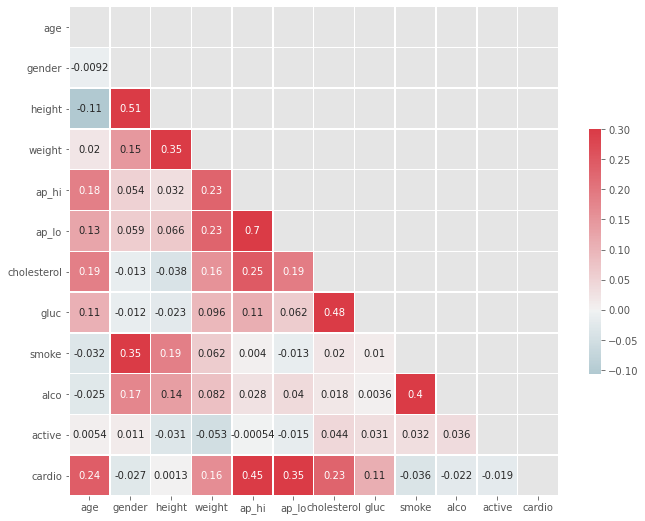

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

corr = cardioData.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [5]:
label="cardio"
target = cardioData[label]
cardioData = cardioData.drop(label, axis=1)

In [6]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cardioData, 
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state=0, 
                                                    stratify=target
                                                   )

In [14]:
# Creating dummy columns for each categorical feature
categorical = []
for col, value in cardioData.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

#categorical = ['alco', 'smoke']
categorical.append('alco')
categorical.append('smoke')

# Store the numerical columns in a list numerical
numerical = cardioData.columns.difference(categorical)        

In [15]:
categorical, numerical

(['alco', 'smoke'],
 Index(['active', 'age', 'ap_hi', 'ap_lo', 'cholesterol', 'gender', 'gluc',
        'height', 'weight'],
       dtype='object'))

### Transform raw features

We can explain raw features by either using a `sklearn.compose.ColumnTransformer` or a list of fitted transformer tuples. The cell below uses `sklearn.compose.ColumnTransformer`. In case you want to run the example with the list of fitted transformer tuples, comment the cell below and uncomment the cell that follows after. 

In [16]:
from sklearn.compose import ColumnTransformer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', LGBMClassifier())])


### Train a SVM classification model, which you want to explain

In [17]:
model = clf.fit(X_train, y_train)

In [18]:
y_pred=model.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average="micro")

from sklearn.metrics import precision_score
pre = precision_score(y_test, y_pred, average='micro')

from sklearn.metrics import recall_score
rec = recall_score(y_test, y_pred, average='micro')


In [22]:
run = experiment.start_logging()
run.log("accuracy", accuracy_score(y_test, y_pred))
run.log("f1_score", f1_score(y_test, y_pred, average="micro"))
run.log("precision", precision_score(y_test, y_pred, average='micro'))
run.log("recall", recall_score(y_test, y_pred, average='micro'))


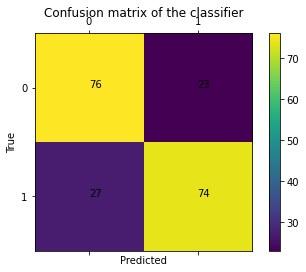

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i][j]))

plt.plot()
run.log_image(name="Confusion_matrix", plot=plt, description='Confusion')

In [24]:
run.complete()

### Explain your model predictions

In [25]:
# 1. Using SHAP TabularExplainer
explainer = TabularExplainer(clf.steps[-1][1], 
                             initialization_examples=X_train, 
                             features=X_train.columns, 
                             classes=['CVD', 'No CVD'], 
                             transformations=transformations)



# 2. Using MimicExplainer
# augment_data is optional and if true, oversamples the initialization examples to improve surrogate model accuracy to fit original model.  Useful for high-dimensional data where the number of rows is less than the number of columns. 
# max_num_of_augmentations is optional and defines max number of times we can increase the input data size.
# LGBMExplainableModel can be replaced with LinearExplainableModel, SGDExplainableModel, or DecisionTreeExplainableModel
# explainer = MimicExplainer(clf.steps[-1][1], 
#                            x_train, 
#                            LGBMExplainableModel, 
#                            augment_data=True, 
#                            max_num_of_augmentations=10, 
#                            features=attritionXData.columns, 
#                            classes=["Leaving", "Staying"], 
#                            transformations=transformations)





# 3. Using PFIExplainer

# Use the parameter "metric" to pass a metric name or function to evaluate the permutation. 
# Note that if a metric function is provided a higher value must be better.
# Otherwise, take the negative of the function or set the parameter "is_error_metric" to True.
# Default metrics: 
# F1 Score for binary classification, F1 Score with micro average for multiclass classification and
# Mean absolute error for regression

# explainer = PFIExplainer(clf.steps[-1][1], 
#                          features=x_train.columns, 
#                          transformations=transformations,
#                          classes=["Leaving", "Staying"])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Generate global explanations
Explain overall model predictions (global explanation)

In [26]:
# Passing in test dataset for evaluation examples - note it must be a representative sample of the original data
# x_train can be passed as well, but with more examples explanations will take longer although they may be more accurate
global_explanation = explainer.explain_global(X_test)

###### Note on how global explanations are being calculated
###### Faster calc for global explanation if that's the only thing that user needs

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
# Print out a dictionary that holds the sorted feature importance names and values
print('global importance rank: {}'.format(global_explanation.get_feature_importance_dict()))

global importance rank: {'ap_hi': 1.4918726789648833, 'age': 0.6291933184473852, 'weight': 0.6076050172055042, 'cholesterol': 0.3221343306617353, 'height': 0.30935157249193107, 'ap_lo': 0.25185350211253177, 'gender': 0.1530601027823972, 'gluc': 0.08657543390968377, 'active': 0.08365527527597878, 'smoke': 0.029051297669245787, 'alco': 0.024068072802709884}


### Generate local explanations
Explain local data points (individual instances)

In [29]:
# You can pass a specific data point or a group of data points to the explain_local function
# E.g., Explain the first data point in the test set
instance_num = 1
local_explanation = explainer.explain_local(X_test[:instance_num])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [31]:
# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = clf.predict(X_test)[instance_num]

sorted_local_importance_values = local_explanation.get_ranked_local_values()[prediction_value]
sorted_local_importance_names = local_explanation.get_ranked_local_names()[prediction_value]

In [32]:
print('local importance values: {}'.format(sorted_local_importance_values))
print('local importance names: {}'.format(sorted_local_importance_names))

local importance values: [[0.009839763522250699, 0.007799903541706848, -0.007647169629192704, -0.013332997249284915, -0.05591846338858849, -0.07118698240079296, -0.216705193366603, -0.29089320825325066, -0.3458396751069753, -0.4077090565348952, -1.0902483140611214]]
local importance names: [['alco', 'age', 'gluc', 'smoke', 'ap_lo', 'active', 'height', 'cholesterol', 'gender', 'weight', 'ap_hi']]


## Visualize
Load the visualization dashboard

In [33]:
from interpret_community.widget import ExplanationDashboard

In [34]:
ExplanationDashboard(global_explanation, model, datasetX=X_test, trueY=y_test.values)

## Upload model explanation to Azure Machine Learning 
Upload the generated explanations to Azure Machine Learning to see the dashboard in [studio](ml.azure.com)

## What is Azure Machine Learning Service?
Azure Machine Learning service is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](./images/aml-overview.png)


In [ ]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

## Connect To Workspace

Just like in the previous tutorials, we will need to connect to a [workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace(class)?view=azure-ml-py).

The following code will allow you to create a workspace if you don't already have one created. You must have an Azure subscription to create a workspace:

```python
from azureml.core import Workspace
ws = Workspace.create(name='myworkspace',
                      subscription_id='<azure-subscription-id>',
                      resource_group='myresourcegroup',
                      create_resource_group=True,
                      location='eastus2')
```

**If you are running this on a Notebook VM, you can import the existing workspace.**

In [ ]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

> **Note:** that the above commands reads a config.json file that exists by default within the Notebook VM. If you are running this locally or want to use a different workspace, you must add a config file to your project directory. The config file should have the following schema:

```
    {
        "subscription_id": "<SUBSCRIPTION-ID>",
        "resource_group": "<RESOURCE-GROUP>",
        "workspace_name": "<WORKSPACE-NAME>"
    }
```

## Create An Experiment

**Experiment** is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [ ]:
from azureml.core import Experiment
experiment_name = 'interpretability_Airlift'
experiment = Experiment(ws, experiment_name)
run = experiment.start_logging()

## Upload 
Upload model explanaion data into Azure Machine Learning.

In [35]:
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient

client = ExplanationClient.from_run(run)
client.upload_model_explanation(global_explanation, comment = "Cardiovascular disease Global Explanation")

## Download 
Download model explanation data.

In [36]:
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient

# Get model explanation data
client = ExplanationClient.from_run(run)
global_explanation = client.download_model_explanation()
local_importance_values = global_explanation.local_importance_values
expected_values = global_explanation.expected_values
global_importance_values = global_explanation.get_ranked_global_values()
global_importance_names = global_explanation.get_ranked_global_names()

In [37]:
print('global importance values: {}'.format(global_importance_values))
print('global importance names: {}'.format(global_importance_names))

global importance values: [1.4918726789648833, 0.6291933184473852, 0.6076050172055042, 0.3221343306617353, 0.30935157249193107, 0.25185350211253177, 0.1530601027823972, 0.08657543390968377, 0.08365527527597878, 0.029051297669245787, 0.024068072802709884]
global importance names: ['ap_hi', 'age', 'weight', 'cholesterol', 'height', 'ap_lo', 'gender', 'gluc', 'active', 'smoke', 'alco']


In [38]:
# Or you can use the saved run.id to retrive the feature importance values
client = ExplanationClient.from_run_id(ws, experiment_name, run.id)
global_explanation = client.download_model_explanation()
local_importance_values = global_explanation.local_importance_values
expected_values = global_explanation.expected_values

In [39]:
# Get the top k (e.g., 4) most important features with their importance values
global_explanation_topk = client.download_model_explanation(top_k=4)
global_importance_values = global_explanation_topk.get_ranked_global_values()
global_importance_names = global_explanation_topk.get_ranked_global_names()

In [40]:
print('global importance values: {}'.format(global_importance_values))
print('global importance names: {}'.format(global_importance_names))

global importance values: [1.4918726789648833, 0.6291933184473852, 0.6076050172055042, 0.3221343306617353]
global importance names: ['ap_hi', 'age', 'weight', 'cholesterol']


In [70]:
import joblib
model_file_name = 'model.pkl'

# save model in the outputs folder so it automatically get uploaded
with open(model_file_name, 'wb') as file:
    joblib.dump(value=clf, filename=os.path.join('./outputs/',
                                                 model_file_name))
    
run.upload_file('model.pkl', os.path.join('./outputs/', model_file_name))
deploy_model = run.register_model(model_name='cvd_deploy_model', 
                                    model_path='model.pkl')

In [71]:
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer, save
# ScoringExplainer
scoring_explainer = TreeScoringExplainer(explainer)
# Pickle scoring explainer locally
save(scoring_explainer, exist_ok=True)

# Register original model


# Register scoring explainer
run.upload_file('cvd_deploy_explainer.pkl', 'scoring_explainer.pkl')
scoring_explainer_model = run.register_model(model_name='cvd_deploy_explainer', model_path='cvd_explainer.pkl')

## Deploy 

Deploy Model and ScoringExplainer.

Please note that you must indicate azureml-defaults with verion >= 1.0.45 as a pip dependency, because it contains the functionality needed to host the model as a web service.

In [54]:
from azureml.core.conda_dependencies import CondaDependencies 

# azureml-defaults is required to host the model as a web service.
azureml_pip_packages = [
    'azureml-defaults==1.13.0', 'azureml-contrib-interpret==1.13.0', 'azureml-core==1.13.0.post1', 'azureml-telemetry==1.13.0',
    'azureml-interpret==1.13.0'
]
 

# Note: this is to pin the scikit-learn and pandas versions to be same as notebook.
# In production scenario user would choose their dependencies
import pkg_resources
available_packages = pkg_resources.working_set
sklearn_ver = None
pandas_ver = None
for dist in available_packages:
    if dist.key == 'scikit-learn':
        sklearn_ver = dist.version
    elif dist.key == 'pandas':
        pandas_ver = dist.version
sklearn_dep = 'scikit-learn'
pandas_dep = 'pandas'
if sklearn_ver:
    sklearn_dep = 'scikit-learn=={}'.format(sklearn_ver)
if pandas_ver:
    pandas_dep = 'pandas=={}'.format(pandas_ver)
# specify CondaDependencies obj
# The CondaDependencies specifies the conda and pip packages that are installed in the environment
# the submitted job is run in.  Note the remote environment(s) needs to be similar to the local
# environment, otherwise if a model is trained or deployed in a different environment this can
# cause errors.  Please take extra care when specifying your dependencies in a production environment.
myenv = CondaDependencies.create(conda_packages=[sklearn_dep, pandas_dep],
                                 pip_packages=['sklearn-pandas', 'pyyaml'] + azureml_pip_packages,
                                 pin_sdk_version=False)

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - sklearn-pandas
  - pyyaml
  - azureml-defaults==1.13.0
  - azureml-contrib-interpret==1.13.0
  - azureml-core==1.13.0.post1
  - azureml-telemetry==1.13.0
  - azureml-interpret==1.13.0
- scikit-learn==0.22.2.post1
- pandas==0.25.3
channels:
- anaconda
- conda-forge



In [ ]:
run.upload_file('myenv.yml', 'myenv.yml')

In [74]:
from azureml.core.model import Model
# retrieve scoring explainer for deployment
scoring_explainer_model = Model(ws, 'cvd_deploy_explainer')

In [78]:
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.model import Model
from azureml.core.environment import Environment


aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "Cardiovascular disease",  
                                                     "method" : "local_explanation"}, 
                                               description='Get local explanations for cardiovascular disease data')

myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score_local_explain.py", environment=myenv)

# Use configs and models generated above
service = Model.deploy(ws, 'cvd-model-scoring', [scoring_explainer_model, deploy_model], inference_config, aciconfig)
service.wait_for_deployment(show_output=True)

Running....................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [97]:
import requests
import json


# Create data to test service with
#sample_data = '{"age":{"899":20228},"gender":{"899":1},"height":{"899":156},"weight":{"899":85.0},"ap_hi":{"899":140},"ap_lo":{"899":90},"cholesterol":{"899":3},"gluc":{"899":1},"smoke":{"899":0},"alco":{"899":0},"active":{"899":1}}'
sample_data = X_test[1:2].to_json()

headers = {'Content-Type':'application/json'}

# send request to service
print("POST to url", service.scoring_uri)
resp = requests.post(service.scoring_uri, sample_data, headers=headers)

# can covert back to Python objects from json string if desired
print("prediction:", resp.text)
result = json.loads(resp.text)

POST to url http://11b8b13a-f5aa-4a71-8295-49606f172524.westeurope.azurecontainer.io/score
prediction: {"predictions": [1], "local_importance_values": [[[-1.7846944983277284, 0.2621668315639571, -0.11725637015805693, 0.44728655388480426, 0.16516284860957536, 0.21105266897741748, 0.1739517301529014, 0.015941599912085148, 0.019031815138688235, -0.01839559170033939, -0.12709788147044443]], [[1.7846944983277284, -0.2621668315639571, 0.11725637015805693, -0.44728655388480426, -0.16516284860957536, -0.21105266897741748, -0.1739517301529014, -0.015941599912085148, -0.019031815138688235, 0.01839559170033939, 0.12709788147044443]]]}


In [147]:
sample_data

'{"age":{"696":21802},"gender":{"696":2},"height":{"696":162},"weight":{"696":62.0},"ap_hi":{"696":130},"ap_lo":{"696":80},"cholesterol":{"696":1},"gluc":{"696":1},"smoke":{"696":0},"alco":{"696":0},"active":{"696":0}}'

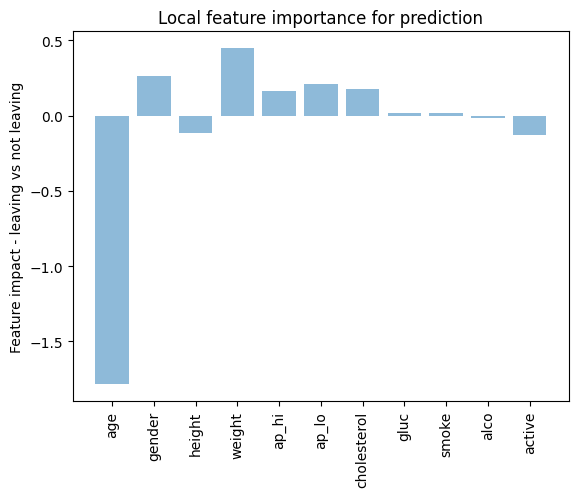

In [98]:
#plot the feature importance for the prediction
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()

labels = json.loads(sample_data)
labels = labels.keys()
objects = labels
y_pos = np.arange(len(objects))
performance = result["local_importance_values"][0][0]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Feature impact - leaving vs not leaving')
plt.title('Local feature importance for prediction')

plt.show()

In [148]:
service.delete()